In [377]:
import pandas as pd
import numpy as np
from scipy.optimize import fsolve, least_squares 
from tqdm import tqdm

In [378]:
##Import the excel file 
sensor_df = pd.read_csv('104.csv')

#Down sample to every 100
sensor_df_smol = sensor_df[0:100000:100]
sensor_df_smol.head()

,sensor ID,norm_secs (secs),time (days)
0,63802,0.000000,39416.607535
100,415483,4.500004,39416.607587
200,161919,9.000008,39416.607639
300,943442,12.500011,39416.607679
400,194738,16.500015,39416.607726


In [379]:
#Import the SMOL attack csv instead of downsampling
sensor_df_smol = pd.read_csv('062.csv')
backbone_sensor_df = sensor_df_smol 
backbone_sensor_df.head()

,sensor ID,norm_secs (secs),time (days)
0,15,11.200029,39423.442618
1,15,11.900031,39423.442626
2,15,12.600032,39423.442634
3,15,13.300034,39423.442642
4,15,14.000036,39423.442650


In [380]:
print(backbone_sensor_df.shape)
print(sensor_df_smol.shape)
print(backbone_sensor_df['sensor ID'].nunique())

(58047, 3)
(58047, 3)
60


In [601]:
#function to check total time between gateways and returns average time
def gateway_total(gateway_x, gateway_y):
    count = 0
    time = 0
    size = backbone_sensor_df.shape[0]
    gateway_path = backbone_sensor_df.values
    
    if(gateway_y == gateway_x):
        return 0
    
    #hyperparameter
    hops = 2
    
    for x in range(size):
        if (gateway_path[x][0] == gateway_x):
            for i in range(-hops,hops+1):
                if (i == 0):
                    continue
                if ((x+i) < 0):
                    continue
                if ((x+i) >= size):
                    continue
                if (gateway_path[x+i][0] == gateway_y):
                    #print("gateway path equals y in else")
                    count += 1
                    time += abs(gateway_path[x+i][1] - gateway_path[x][1])
                                        
    if (count >= 1): 
        #print(count)
        return time/count
    else:
        return 0 #could change this to a negative number to indicate doesn't exist 
        
#gateway_total(1,20)


In [602]:
#print(backbone_sensor_df.values[5])

[1.50000000e+01 1.47000378e+01 3.94234427e+04]


In [603]:
##Testing the time 
#ids = np.array([1,2,3])
#times = np.array([0.5,1.5,1.75])
#gateways_path = np.array([ids,times]).T
#print(gateways_path)

#gateway_total(2,1)

In [604]:
#set up a matrix of time between adjacent gateways, this is a proxy for distance
num_gates = backbone_sensor_df['sensor ID'].nunique()
time_pairs = np.zeros((num_gates,num_gates))
gateway_ids = backbone_sensor_df['sensor ID'].drop_duplicates().values

for x in tqdm(range(num_gates)):
    #times = []
    for y in range(num_gates):
        #find how many times x gateway is adjacent to y gateway 
        gateway_id_x = gateway_ids[y]
        gateway_id_y = gateway_ids[x]
        average = gateway_total(gateway_id_x,gateway_id_y)

        #add to time_pairs[x][y]
        time_pairs[x][y] = average
        
        
time_pairs

100%|██████████| 60/60 [00:58<00:00,  1.03it/s]


array([[  0.        ,   4.56884087, 164.96709107, ...,   0.        ,
          0.        ,   0.        ],
       [  4.56884087,   0.        ,  47.9981627 , ...,   0.        ,
         53.90013867,   0.        ],
       [164.96709107,  47.9981627 ,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [  0.        ,   0.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       [  0.        ,  53.90013867,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ]])

0.0


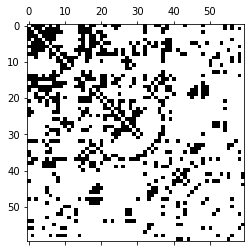

In [605]:
import scipy.sparse as sparse 
print(time_pairs[2,2])
plt.spy(time_pairs)
plt.show()

In [433]:
#get the average velocity from the ground truth data 
avg_vel = 2 #m/s

In [606]:
#calculate the distance matrix from the average time and average velocity 
distance = avg_vel*time_pairs
distance
print(distance.shape)

(60, 60)


In [607]:
#pick three gateways to triangulate from ground truth
#gateway_a = [231.2663,120.1813]
#gateway_b = [197.9663,793.9513]
#gateway_c = [757.0289,350.5063]

#x1 = gateway_a[0]
#y1 = gateway_a[1]

#x2 = gateway_b[0]
#y2 = gateway_b[1]

#x3 = gateway_c[0]
#y3 = gateway_c[1]

##Import the ground truth file 
truth_df = pd.read_csv('sensors.csv')
truth_df.head()

#get the ground truth values for the gateway ids of interest
truth_df_filtered = truth_df[truth_df['sensor ID'].isin(gateway_ids)]
truth_df_filtered.head()

,sensor ID,x (m),y (m),radius (m)
0,0,231.2663,120.1813,11.131326
1,1,371.8589,238.2076,11.634567
2,2,757.0289,350.5063,15.115731
3,3,190.9400,140.1613,13.697470
4,4,663.1340,522.3010,14.227241


In [608]:
#set up a dictionary with three initial known gateway locations
known_gateway_ids = [49,19,26]
gateway_a = [truth_df['x (m)'][known_gateway_ids[0]],truth_df['y (m)'][known_gateway_ids[0]]]
gateway_b = [truth_df['x (m)'][known_gateway_ids[1]],truth_df['y (m)'][known_gateway_ids[1]]]
gateway_c = [truth_df['x (m)'][known_gateway_ids[2]],truth_df['y (m)'][known_gateway_ids[2]]]
known_gateway_locations = (gateway_a,gateway_b,gateway_c)
known_location_dict = dict(zip(known_gateway_ids,known_gateway_locations))
print(known_location_dict[49])

[427.0369999997256, 65.31399999981295]


In [609]:
#function to return the distance error between points
def distance_err(point):
    x = point[0]
    y = point[1]
    x1,y1 = known_location_dict[known_gateway_ids[0]]
    x2,y2 = known_location_dict[known_gateway_ids[1]]
    x3,y3 = known_location_dict[known_gateway_ids[2]]
    error1 = np.abs(np.linalg.norm(np.array([x,y])-np.array([x1,y1])) - d1)**2
    error2 = np.abs(np.linalg.norm(np.array([x,y])-np.array([x2,y2])) - d2)**2
    error3 = np.abs(np.linalg.norm(np.array([x,y])-np.array([x3,y3])) - d3)**2
    error_total = error1 + error2 + error3
    
    return error_total 

#Example use of 
#least_squares(fun,[16000,25000])

In [610]:
#for each gateway get the location 
positions_x = []
positions_y = []
known_gateways = []

#loop through gateways 
for i in range(len(gateway_ids)):
    gateway = gateway_ids[i]
    d1 = distance[i][known_gateway_ids[0]]
    d2 = distance[i][known_gateway_ids[1]]
    d3 = distance[i][known_gateway_ids[2]]
    
    #print(d1)
    #print(d2)
    #print(d3)
    #print("")
    
    if (int(d1) != 0) & (int(d2) != 0) & (int(d3) != 0):
        print(d1)
        print(d2)
        print(d3)
        positions_x.append(least_squares(distance_err,[400,400]).x[0])
        positions_y.append(least_squares(distance_err,[400,400]).x[1])
        known_gateways.append(gateway)

zipped = list(zip(known_gateways,positions_x,positions_y))
positions = pd.DataFrame(zipped, columns = ['gateway_ids','positions_x','positions_y'])
positions_x = []
positions_y = []
known_gateways = []
positions.head()

,gateway_ids,positions_x,positions_y


In [611]:
#get gateway_id position error 

error = np.zeros(60)
for i in range(len(gateway_ids)):
    gateway = gateway_ids[i]
    truth_data = truth_df[truth_df['sensor ID'] == gateway]
    x = truth_data['x (m)'].values
    y = truth_data['y (m)'].values
    
    position_data = positions[positions['gateway_ids'] == gateway]
    x_est = position_data['positions_x'].values
    y_est = position_data['positions_y'].values
    
    error[i] = np.linalg.norm(np.array([x,y])-np.array([x_est,y_est]))
    
print(error)

TypeError: loop of ufunc does not support argument 0 of type NoneType which has no callable sqrt method

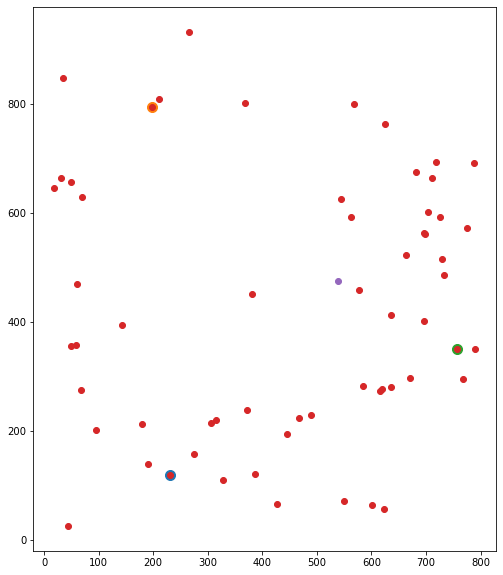

In [472]:
from matplotlib import pyplot as plt
plt.figure(figsize=(18, 10))
plt.gca().set_aspect("equal")
plt.scatter(x1,y1,s=100,marker='o')
plt.scatter(x2,y2,s=100,marker='o')
plt.scatter(x3,y3,s=100,marker='o')
plt.scatter(truth_df_filtered["x (m)"], truth_df_filtered["y (m)"])
plt.scatter(positions['positions_x'], positions['positions_y'])
plt.show()

In [ ]:
#bring in other sensor traces 
#figure out your for loopin problem 

In [ ]:
#Unused function to check how many times gateways are next to each other and return average time 
def gateway_adjacent(gateway_x, gateway_y):
    #print(gateway_x)
    #print(gateway_y)
    
    count = 0
    time = 0
    size = backbone_sensor_df.shape[0]
    #print(size)
    for x in range(size):
        if (backbone_sensor_df.iloc[x][0] == gateway_x):
            #if it's the first index 
            if (x == 0):
                if (backbone_sensor_df.iloc[x+1][0] == gateway_y):
                    count += 1
                    time += abs(backbone_sensor_df.iloc[x+1][1] - backbone_sensor_df.iloc[x][1])
            
            #if it's a last index
            elif (x == size-1):
                if (backbone_sensor_df.iloc[x-1][0] == gateway_y):
                    count += 1
                    time += abs(backbone_sensor_df.iloc[x-1][1] - backbone_sensor_df.iloc[x][1])
            
            else:
                if (backbone_sensor_df.iloc[x+1][0] == gateway_y):
                    count += 1
                    time += abs(backbone_sensor_df.iloc[x+1][1] - backbone_sensor_df.iloc[x][1])
                elif (backbone_sensor_df.iloc[x-1][0] == gateway_y):
                    count += 1
                    time += abs(backbone_sensor_df.iloc[x-1][1] - backbone_sensor_df.iloc[x][1])
                    
    if (count >= 1): 
        return time/count
    else:
        return 0

In [ ]:
#filter to adjadent gateways with a time difference larger than 3 seconds

#take this out? Can we just use the smol attack data directly

#diff_sensor_df = sensor_df_smol.diff()
#print(diff_sensor_df[40:60])
#print(sensor_df_smol[40:60])
#[diff_sensor_df['norm_secs (secs)'] > 5]

#backbone_sensor_df = sensor_df_smol 
#backbone_sensor_df.head()